In [1]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.5_dps.py
create a topo stack for each tile

In [2]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Build the COMPLETED list of Topo tiles - s3fs implementation

In [9]:
%%time
import s3fs
s3 = s3fs.S3FileSystem()
bucket = "s3://maap-ops-workspace"
MAAP_VERSION = "ops"
searchkey_list = [f'nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/{MAAP_VERSION}/2021/09/{DAY}/**/*_stack.tif' for DAY in ['15','16']]
# Concat list of lists to data frame
topo_path_df = pd.concat([pd.DataFrame(s3.glob(os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_list])

#Convert data frame to list
COMPLETED_TILES_LIST = [i.replace("maap-ops-workspace", "https://maap-ops-workspace.s3.amazonaws.com") for i in topo_path_df.maap_path.to_list()]
len(COMPLETED_TILES_LIST)

CPU times: user 3.59 s, sys: 44.3 ms, total: 3.63 s
Wall time: 5.95 s


3177

#### Get new tiles for version 2

              count
tile_version       
version 1      4551
version 2       639


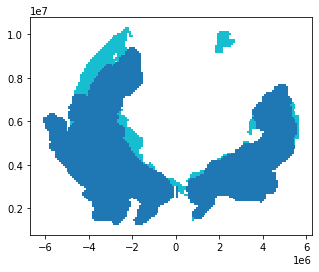

In [17]:
# Get all boreal tiles
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v002.gpkg' #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
boreal_tile_index = gpd.read_file(boreal_tile_index_path)
boreal_tile_index.astype({'layer':'int'})
boreal_tile_index.rename(columns={"layer":"tile_num"}, inplace=True)
boreal_tile_index["tile_num"] = boreal_tile_index["tile_num"].astype(int)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.
if True:
    # Remove bad tiles
    boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

boreal_tile_index.plot(column='tile_version')
print(boreal_tile_index.groupby('tile_version')['tile_group'].agg(['count']))

INPUT_TILE_NUM_LIST = boreal_tile_index[boreal_tile_index.tile_version == 'version 2'].tile_num.to_list()
VER1_TILE_NUM_LIST = boreal_tile_index[boreal_tile_index.tile_version == 'version 1'].tile_num.to_list()

In [10]:
print(
    len(INPUT_TILE_NUM_LIST),
    len(VER1_TILE_NUM_LIST),
    len(COMPLETED_TILES_LIST)
)

639 4551 3177


In [13]:
TEST_DPS  = True

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
    print(DPS_INPUT_TILE_NUM_LIST)
else:
    print('Running DPS on the FULL list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    

Running DPS on a SUBSET list of input
[42558, 42559, 42560, 42745, 42746, 42935, 42936, 43326, 45716, 45970]


# Run a DPS of topo tiles

In [16]:
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = 'do_topo_stack_3-1-5'
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-8gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v002.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'tile_buffer_m': 120,
                         'in_tile_layer': 'boreal_tiles_v002',
                         'topo_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/dem30m_tiles.geojson',
        }

    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version='master',
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, len_input_list]:
        print(f"DPS run #: {DPS_num} | tile num: {INPUT_TILE_NUM} | submit status: {submit_result['status']} | job id: {submit_result['job_id']}") 

# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
submit_results_df.to_csv(f'/projects/my-public-bucket/DPS_topo_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

DPS run #: 1 | tile num: 42558 | submit status: failed | job id: 
DPS run #: 10 | tile num: 45970 | submit status: failed | job id: 


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type
0,failed,500,,1,42558,2022-03-09 19:17:58.380322,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,2,42559,2022-03-09 19:17:58.423774,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,3,42560,2022-03-09 19:17:58.484936,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,4,42745,2022-03-09 19:17:58.538037,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,5,42746,2022-03-09 19:17:58.590926,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,6,42935,2022-03-09 19:17:58.641662,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,7,42936,2022-03-09 19:17:58.682702,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,8,43326,2022-03-09 19:17:58.724856,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,9,45716,2022-03-09 19:17:58.764028,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb
0,failed,500,,10,45970,2022-03-09 19:17:58.802822,19,do_topo_stack_3-1-5_ubuntu,nathanmthomas,maap-dps-worker-8gb


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the _submit_results_df_ from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the _submit_results_df_ --> this tells you which specific granules (or tile nums) failed
3. building another input list of tiles for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [ ]:
%%time
def BUILD_TABLE_JOBSTATUS(submit_results_df):
    import xmltodict
    df = pd.concat([pd.DataFrame(xmltodict.parse(maap.getJobStatus(job_id).content)).transpose() for job_id in submit_results_df.job_id.to_list()])
    return df

job_status_df = BUILD_TABLE_JOBSTATUS(submit_results_df)
#print(job_status_df.head())

num_jobs = submit_results_df.shape[0]
z = submit_results_df.merge(job_status_df, how='left', left_on='job_id', right_on='wps:JobID')

print(f'Count total jobs:\t{num_jobs}')
print(f"Count pending jobs:\t{z[z['wps:Status'] =='Accepted'].shape[0]}")
print(f"Count running jobs:\t{z[z['wps:Status'] =='Running'].shape[0]}")
print(f"Count succeeded jobs:\t{z[z['wps:Status'] =='Succeeded'].shape[0]}")
print(f"Count failed jobs:\t{z[z['wps:Status'] =='Failed'].shape[0]}")
print(f"% of failed jobs:\t{round(z[z['wps:Status'] =='Failed'].shape[0] / ( z[z['wps:Status'] =='Failed'].shape[0] + z[z['wps:Status'] =='Succeeded'].shape[0] ), 4) * 100}")